# Digit Recognition 
## 1. Introduction
In this Project we created a program that can recognize hand drawn digits using the k nearest neighbors (KNN) algorithm. 
We used two different MNIST data sets containing 20 by 20 hand drawn images with the digits 0 to 9. They are greyscaled,
and centered around their center off mass. There are two different sets of pictures one set of training pictures 
and one set of test images. Each picture also has a label attached to it so program knows the number the digit resembles.
We used a KNN algorithm to predict the right digit (...). We also performed a principle component analysis (PCA) to 
reduce the dimensions (...). By doing so we reduce the dimensions with the lowest variance so that only the
components remain with the highest amount of variance.



# 2. Import functions
In python you need to import functions such as for plotting to actually to able to create plots. Below are all the 
neccessary plots used for this program. 

In [ ]:
import src.knn as knn
%matplotlib inline
import src.pca as pca
import src.pickle_operations as pickle_io
import matplotlib.pyplot as plt
import src.plot as plot
from src import KNN_sklearn as knn_sklearn
from src import meta_digit_operations as meta_digit
from src import knn_clustering
import numpy as np
from src import load_image_vectors
print("done")


# 3. Loading test and trainings images from MNIST dataset
   First, the training and test images are loaded from the MNISt dataset and saved in training and test list. 
   

In [51]:
 # load training and test images - only necessary once combined with saving as pickle
training_lists = load_image_vectors.load_gz('data/mnist_train.csv.gz')
print("Successfully loaded training list")
test_lists = load_image_vectors.load_gz('data/mnist_test.csv.gz')
print("Successfully loaded test list")
    

 


60000
Successfully loaded training list
10000
Successfully loaded test list


# 4. Test for digit prediction
Test to see if the digit recognition works right. Plots first ten images from test image lists and writs the digit 
prediction below each image. 



thingy initialized
[[0, 7], [1, 2], [2, 1], [3, 0], [4, 4], [5, 1], [6, 4], [7, 9], [8, 5], [9, 9]]


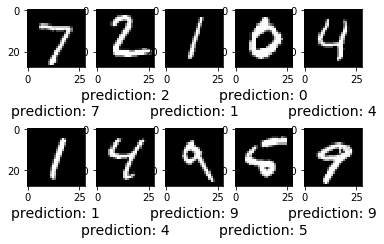

In [39]:
knn_sklearn.plot_sample_recognitions(training_lists, test_lists)
print("done")


# 5. K accuracy test
In this step we try to determine the best amount of k nearest neighbors we should use to have the most accurate prediction
possible. The function plots a bar chart for various k values and shows the percentage with which the digit was predicted right.
The plot shows that 3 is the optimal value for k. That means for k=3 neighbours our KNN algorithm predicts the right digit with around 97%



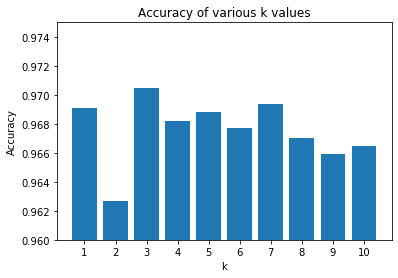

In [20]:
# runs the k_accuracy test with 10000 images between the chosen k values (k_min, k_max) > then plots the result
# plot.k_accuracy_test(training_lists, test_lists, 1, 4)  # saves the result as k_accuracy2 to avoid time wasted
plot.plot_k_accuracy(pickle_io.load_pickles("src/k_accuracy.dat"))
print("done")
    

# 6. PCA variance analysis
After that, the PCA variance is determined and plotted so we can find out the amount of dimensions neccessary 
to have the highest accuracy to predict the right digit. For our program we used an explained variance of 95%
which as you can see is plotted at around 150 dimensions.


Started pca_variance_analysis
done


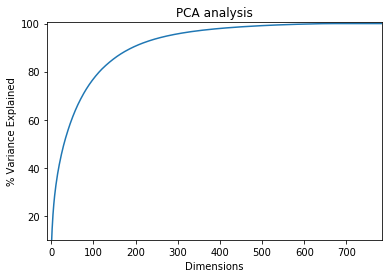

In [40]:

# runs the pca_variance_analysis and plots it
plot.pca_variance_analysis([csv_image.image for csv_image in test_lists])
print("done")


#7. Plotted images with reduced dimensions
This function plots the original image shown on the left side and on the right side the images with reduced dimensions.

thingy initialized
done


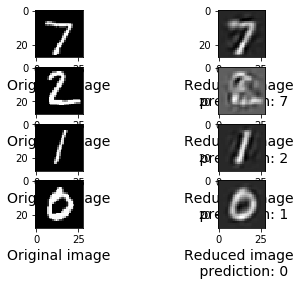

In [53]:
reduced_images = pca.reduce_dimensions([csv_image.image for csv_image in training_lists], [csv_image.image for csv_image in test_lists], 100)
pca.plot_sample_reductions(reduced_images[2], training_lists, test_lists, reduced_images[0],  reduced_images[1], reduced_images[3], 100)
print("done")


# 8.

In [54]:
# Get reduces training and test images as tuple - reduced_images[0] is train_list, [1] is test_list without digits
reduced_images = pca.reduce_dimensions([csv_image.image for csv_image in training_lists],
                                       [csv_image.image for csv_image in test_lists], 784)
print("PCA finished successfully")

PCA finished successfully


Reverses the PCA and plots the image back to its original stae

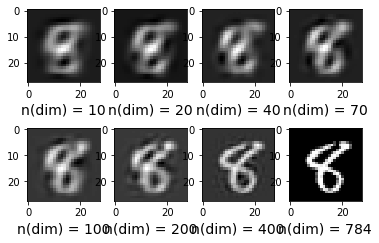

done


In [43]:
pca.plot_inverse_transforms(reduced_images[2], reduced_images[1], reduced_images[3])
print("done")

# PCA accuracy test
After that, the PCA variance is determined and plotted so we can find out the amount of dimensions neccessary 
to have the highest accuracy to predict the right digit. For our program we used an explained variance of 95%
which as you can see is plotted at around 150 dimensio

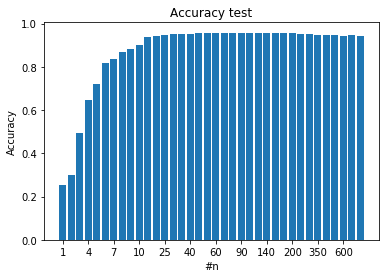

done


In [45]:
plot.plot_pca_accuracy(pickle_io.load_pickles("src/pca_accuracy.dat"))
print("done")

Shows the most recognazible test digits for each digit from zero to nine calculated with the mean distance
of each training image with the same label as the digit.


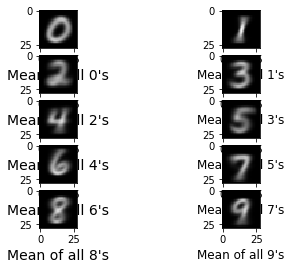

done


In [47]:
meta_digit.show_mean_digits(training_lists)
print("done")

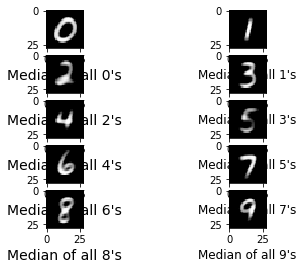

done


In [48]:
meta_digit.show_median_digits(training_lists)
print("done")

In [37]:
%load_ext autoreload
%autoreload 2
best_digits = np.asarray([csv_image.image for csv_image in meta_digit.get_best_digits(training_lists, test_lists)])
print("done")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
i: 0
success: i = 10
max_accuracy: 1.0, max_label: 1, true label: 10
i: 1
success: i = 2
max_accuracy: 1.0, max_label: 0, true label: 2
i: 2
success: i = 147
max_accuracy: 1.0, max_label: 10, true label: 147
i: 3
success: i = 500
max_accuracy: 1.0, max_label: 45, true label: 500
i: 4
success: i = 7879
max_accuracy: 0.988, max_label: 777, true label: 7879
i: 5
success: i = 6908
max_accuracy: 0.998, max_label: 623, true label: 6908
i: 6
success: i = 130
max_accuracy: 1.0, max_label: 12, true label: 130
i: 7
success: i = 494
max_accuracy: 1.0, max_label: 48, true label: 494
i: 8
success: i = 3197
max_accuracy: 1.0, max_label: 302, true label: 3197
i: 9
success: i = 7336
max_accuracy: 0.98, max_label: 751, true label: 7336
done


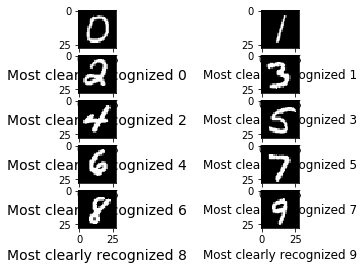

In [49]:
meta_digit.show_best_digits(training_lists, test_lists, best_digits)

thingy initialized
got preds
[[0, 0, 10, 0, 0, 4, 6, 1, 7, 8], [0, 0, 5, 2, 0, 1, 3, 17, 2, 5], [3, 3, 0, 3, 4, 1, 2, 13, 7, 5], [0, 0, 4, 0, 1, 15, 0, 3, 18, 11], [0, 0, 2, 0, 0, 3, 1, 7, 7, 15], [2, 0, 0, 12, 0, 0, 7, 0, 13, 5], [3, 3, 5, 2, 6, 7, 0, 0, 2, 0], [1, 0, 5, 11, 3, 2, 0, 0, 5, 15], [0, 0, 11, 18, 5, 7, 2, 1, 0, 4], [0, 1, 1, 6, 23, 6, 0, 26, 5, 0]]


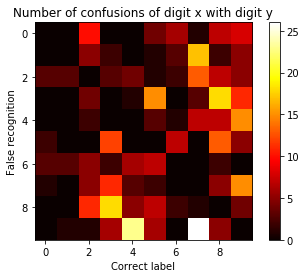

In [50]:
knn_clustering.get_mispredictions(training_lists, test_lists)
print("done")


If the digit was wrong predicted it is plotted to show what is wrong with the digit  

thingy initialized
here
[[0, 7], [1, 2], [2, 1], [3, 0], [4, 4], [5, 1], [6, 4], [7, 9], [8, 5], [9, 9], [10, 0], [11, 6], [12, 9], [13, 0], [14, 1], [15, 5], [16, 9], [17, 7], [18, 3], [19, 4]]
1
2
3
here2
4
5
35
here2
7
8
67
here2
10
11
99
here2
13
14
131
here2


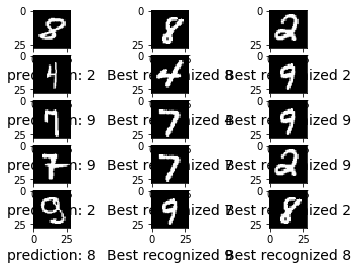

In [38]:
knn_sklearn.show_wrong_predicted(training_lists, test_lists, best_digits)    